In [4]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
from snntorch import spikegen, surrogate
import matplotlib.pyplot as plt
from utils import load_dataset_df, smile_to_fp,smiles_to_descriptor,smiles_to_onehot, smiles_to_onehot_selfies, data_splitter, get_spiking_net, make_filename
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score
from csnn_model import CSNNet, get_prediction_fn, bias

#### Load DataFrame

In [5]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[0]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


NR-AR 7265 0.04
NR-AR-LBD 6758 0.04
NR-AhR 6549 0.12
NR-Aromatase 5821 0.05
NR-ER 6193 0.13
NR-ER-LBD 6955 0.05
NR-PPAR-gamma 6450 0.03
SR-ARE 5832 0.16
SR-ATAD5 7072 0.04
SR-HSE 6467 0.06
SR-MMP 5810 0.16
SR-p53 6774 0.06


In [6]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### Molecular Representation

In [7]:
representations = ["fp", "descriptor", "SELFIES-1hot", "SMILES-1hot"]#, "graph-list"]

repr_type = representations[1]

In [8]:
if repr_type == "fp":
    fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['count_morgan', 1024], ['pubchem', 881]]
    mix = True
    fp_type, num_bits = fp_types[1]
    if mix and fp_type == 'RDKit':
        num_bits = 512
    data_config = {"fp_type": fp_type,
                "num_bits": num_bits,
                "radius": 2,
                "fp_type_2": fp_types[0][0],
                "num_bits_2": 1024 - num_bits,
                "mix": mix,}
    dim_2 = False
    print(fp_type, '-', num_bits)
    if mix: print(data_config['fp_type_2'], '-', data_config['num_bits_2'])
    if dim_2: print("2D FP")

elif repr_type == "descriptor":
    desc_type = ["RDKit", "TODO"]
    data_config = {"desc": desc_type[0],
                   "size": 0,
                }
elif repr_type == "SELFIES-1hot":
    dim_2 = True
    data_config = {}

elif repr_type == "SMILES-1hot":
    dim_2 = True
    data_config = {}

data_config["repr_type"] = repr_type
print(repr_type)

descriptor


In [9]:
dtype = torch.float32
split = "scaffold"
dataset = None

if dirname != 'BBBP':
    split = "random"
    if repr_type == "fp":
        fp_array, target_array = smile_to_fp(df, data_config=data_config, target_name=target_name)
        # Create Torch Dataset
        fp_tensor = torch.tensor(fp_array, dtype=dtype)
        print(fp_tensor.size())
        target_tensor = torch.tensor(target_array, dtype=dtype).long()
        if dim_2:
            fp_tensor = fp_tensor.view(-1, 32, 32)
            print(fp_tensor.size())
        dataset = TensorDataset(fp_tensor, target_tensor)
    elif repr_type == "descriptor":
        desc_array, target_array = smiles_to_descriptor(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        desc_tensor = torch.tensor(desc_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(desc_tensor, target_tensor)
        print(desc_tensor.size())
    elif repr_type == "SELFIES-1hot":
        selfies_array, target_array = smiles_to_onehot_selfies(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        selfies_tensor = torch.tensor(selfies_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(selfies_tensor, target_tensor)
        print(selfies_tensor.size())
    elif repr_type == "SMILES-1hot":
        smiles_array, target_array = smiles_to_onehot(df, data_config=data_config, target_name=target_name, missing_val=0)
        # Create Torch Dataset
        smiles_tensor = torch.tensor(smiles_array, dtype=dtype)
        target_tensor = torch.tensor(target_array, dtype=dtype).long()

        dataset = TensorDataset(smiles_tensor, target_tensor)
        print(smiles_tensor.size())

[15:14:28] Explicit valence for atom # 8 Al, 6, is greater than permitted


Inf in descriptor MaxPartialCharge for molecule CC1=C2N=C(C=C3N=C(C(C)=C4[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@](C)([C@@H]5N=C1[C@](C)(CCC(=O)NC[C@@H](C)OP(=O)([O-])O[C@@H]1[C@@H](CO)O[C@H](n6cnc7cc(C)c(C)cc76)[C@@H]1O)[C@H]5CC(N)=O)N4[Co+]C#N)[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O
Inf in descriptor MinPartialCharge for molecule CC1=C2N=C(C=C3N=C(C(C)=C4[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@](C)([C@@H]5N=C1[C@](C)(CCC(=O)NC[C@@H](C)OP(=O)([O-])O[C@@H]1[C@@H](CO)O[C@H](n6cnc7cc(C)c(C)cc76)[C@@H]1O)[C@H]5CC(N)=O)N4[Co+]C#N)[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O
Inf in descriptor MaxAbsPartialCharge for molecule CC1=C2N=C(C=C3N=C(C(C)=C4[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@](C)([C@@H]5N=C1[C@](C)(CCC(=O)NC[C@@H](C)OP(=O)([O-])O[C@@H]1[C@@H](CO)O[C@H](n6cnc7cc(C)c(C)cc76)[C@@H]1O)[C@H]5CC(N)=O)N4[Co+]C#N)[C@@](C)(CC(N)=O)[C@@H]3CCC(N)=O)C(C)(C)[C@@H]2CCC(N)=O
Inf in descriptor MinAbsPartialCharge for molecule CC1=C2N=C(C=C3N=C(C(C)=C4[C@@H](CCC(N)=O)[C@](C)(CC(N)=

[15:14:32] Explicit valence for atom # 3 Al, 6, is greater than permitted
[15:14:32] Explicit valence for atom # 4 Al, 6, is greater than permitted


Inf in descriptor MaxPartialCharge for molecule CCCCCCCCCCCC(=O)O[Sn](CCCC)(CCCC)OC(=O)CCCCCCCCCCC
Inf in descriptor MaxAbsPartialCharge for molecule CCCCCCCCCCCC(=O)O[Sn](CCCC)(CCCC)OC(=O)CCCCCCCCCCC


[15:14:37] Explicit valence for atom # 4 Al, 6, is greater than permitted
[15:14:41] Explicit valence for atom # 9 Al, 6, is greater than permitted
[15:14:41] Explicit valence for atom # 5 Al, 6, is greater than permitted
[15:14:45] Explicit valence for atom # 16 Al, 6, is greater than permitted


torch.Size([5825, 217])


In [13]:
if repr_type == "SMILES_1hot":
    longest_smiles = df.loc[df['smiles'].str.len().idxmax(), 'smiles']
    print(longest_smiles)

    from rdkit import Chem

    mol = Chem.MolFromSmiles(longest_smiles)
    print("Valid" if mol else "Invalid")
    cc = df[df['smiles'].str.len() > 256]

    print(len(cc))
    sample1 = smiles_array[0]
    print(sample1)
    print(selfies_tensor.size())

In [14]:
if repr_type == "descriptor":
    from rdkit.Chem import  Descriptors
    print("desc_array Has NaNs:", np.isnan(desc_array).any())
    print("desc_array Has Infs:", np.isinf(desc_array).any())
    print("desc_tensor has nans:", torch.isnan(desc_tensor).any().item())
    print("desc_tensor has infs:", torch.isinf(desc_tensor).any().item())

    print("Max value in desc_array:", np.max(desc_array))

    # Find the index of the max value in the array
    max_idx = np.argmax(desc_array)  # Returns the index of the max value in flattened array

    # Find the corresponding row and descriptor index
    row_idx = max_idx // desc_array.shape[1]  # Row index (which molecule)
    desc_idx = max_idx % desc_array.shape[1]  # Descriptor index (which descriptor)
    print(f"Max value at row {row_idx}, descriptor {desc_idx} with value: {desc_array[row_idx, desc_idx]}")

    for k, (nm, fn) in enumerate(Descriptors._descList):
        print(k, nm)


desc_array Has NaNs: False
desc_array Has Infs: False
desc_tensor has nans: False
desc_tensor has infs: False
Max value in desc_array: 90564.3788812275
Max value at row 2038, descriptor 128 with value: 90564.3788812275
0 MaxAbsEStateIndex
1 MaxEStateIndex
2 MinAbsEStateIndex
3 MinEStateIndex
4 qed
5 SPS
6 MolWt
7 HeavyAtomMolWt
8 ExactMolWt
9 NumValenceElectrons
10 NumRadicalElectrons
11 MaxPartialCharge
12 MinPartialCharge
13 MaxAbsPartialCharge
14 MinAbsPartialCharge
15 FpDensityMorgan1
16 FpDensityMorgan2
17 FpDensityMorgan3
18 BCUT2D_MWHI
19 BCUT2D_MWLOW
20 BCUT2D_CHGHI
21 BCUT2D_CHGLO
22 BCUT2D_LOGPHI
23 BCUT2D_LOGPLOW
24 BCUT2D_MRHI
25 BCUT2D_MRLOW
26 AvgIpc
27 BalabanJ
28 BertzCT
29 Chi0
30 Chi0n
31 Chi0v
32 Chi1
33 Chi1n
34 Chi1v
35 Chi2n
36 Chi2v
37 Chi3n
38 Chi3v
39 Chi4n
40 Chi4v
41 HallKierAlpha
42 Ipc
43 Kappa1
44 Kappa2
45 Kappa3
46 LabuteASA
47 PEOE_VSA1
48 PEOE_VSA10
49 PEOE_VSA11
50 PEOE_VSA12
51 PEOE_VSA13
52 PEOE_VSA14
53 PEOE_VSA2
54 PEOE_VSA3
55 PEOE_VSA4
56 PEOE_V

#### Loss Function

In [15]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['ce_mem', 'rate_loss', 'count_loss', 'temporal_loss', 'bce_loss']
loss_type = loss_types[2]
print(loss_type)


count_loss


#### Train Loop

In [16]:
net_types = ["SNN", "DSNN", "CSNN", "RSNN"]
net_type = net_types[2]
slope = 10
#spike_grad = surrogate.fast_sigmoid(slope=slope)
spike_grad = None
beta = 0.95 

net_config = {
            "num_hidden": 512,
            "num_hidden_l2": 256,
            "time_steps": 10,
            "spike_grad": spike_grad,
            "slope": None if not spike_grad else slope, #spike_grad.__closure__[0].cell_contents,
            "beta": beta,
            "encoding": 'rate' if loss_type != 'temporal_loss' else 'ttfs',
            "bias": bias,
            "out_num": 2
            }

if repr_type == "fp":
    net_config["input_size"] = 1024 if data_config['mix'] else num_bits
    net_config["2d"] = dim_2

elif repr_type == "descriptor":
    net_config["input_size"] = desc_tensor.shape[1]
    net_config["2d"] = False
    net_config["time_steps"] = 50

if repr_type == "SELFIES-1hot":
    net_config["input_size"] = [desc_tensor.shape[1],desc_tensor.shape[2]] 
    net_config["2d"] = True
if repr_type == "SMILES-1hot":
    net_config["2d"] = True
    net_config["input_size"] = [desc_tensor.shape[1],desc_tensor.shape[2]] 
print(net_type)

CSNN


In [17]:
   
pop_coding = net_config['out_num'] > 2
lr=1e-4 #1e-6 default for 1000 epochs. csnn requires higher
iterations = 30
weight_decay = 0 # 1e-5
optim_type = 'Adam'
#optim_type = 'SGD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16 #16, 8
train_config = {"num_epochs": 200,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['time_steps'],
                'val_net': None,
                'prediction_fn': get_prediction_fn(encoding=net_config['encoding'], pop_coding=pop_coding),
                }
drop_last = net_type == "CSNN"
pin_memory = device == "cuda"
save_csv = False
save_models = False
results = [[], [], [], [], [], []]

cuda


In [18]:
print("-----Configuration-----")
print(net_config)
print(train_config)

-----Configuration-----
{'num_hidden': 512, 'num_hidden_l2': 256, 'time_steps': 50, 'spike_grad': None, 'slope': None, 'beta': 0.95, 'encoding': 'rate', 'bias': True, 'out_num': 2, 'input_size': 217, '2d': False}
{'num_epochs': 200, 'batch_size': 16, 'device': device(type='cuda'), 'loss_type': 'count_loss', 'loss_fn': None, 'dtype': torch.float32, 'num_steps': 50, 'val_net': None, 'prediction_fn': <function prediction_spk_rate at 0x0000021177B41BD0>}


In [19]:
from rdkit import RDLogger

# Disable RDKit logging for the scaffold meeting
RDLogger.DisableLog('rdApp.*')


In [20]:
def calc_metrics(metrics_list, all_targets, all_preds):
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    
    metrics_list[0].append(accuracy)
    metrics_list[1].append(auc_roc)
    metrics_list[2].append(sensitivity)
    metrics_list[3].append(specificity)
    metrics_list[4].append(f1)
    metrics_list[5].append(precision)
    

In [ ]:
def zscore_norm(train_subset, val_subset, test_subset):
    train_tensor, _ = train_subset[:]
    val_tensor, _ = val_subset[:]
    test_tensor, _ = test_subset[:]

    mean = train_tensor.mean(dim=0)
    std = train_tensor.std(dim=0)
    std = std.clamp(min=1e-6)
    #print(mean.size())
    train_norm = (train_tensor - mean)
    #print(torch.isnan(train_tensor).any())
    #print(torch.isnan(train_norm).any())
    train_norm = train_norm / std
    #print(torch.isnan(train_norm).any())
    val_norm = (val_tensor - mean) / std
    test_norm = (test_tensor - mean) / std

    return train_norm, val_norm, test_norm

In [22]:
import time
times = []

In [ ]:
train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, data_config=data_config, seed=1, dtype=dtype)
train_desc, train_label = train[:]
_, val_label = val[:]
_, test_label = test[:]
train_tensor, _ = train[:]
mean = train_tensor.mean(dim=0)
print("train has nans:", torch.isnan(train_tensor).any().item())
print("train has infs:", torch.isneginf(train_tensor).any().item())
print("train has infs:", torch.isinf(train_tensor).any().item())


print("mean size:", mean.size())
print("mean has nans:", torch.isnan(mean).any().item())
print("mean has infs:", torch.isneginf(mean).any().item())
print("train has infs:", torch.isinf(mean).any().item())

result = train_tensor - mean
print("train has nans:", torch.isnan(result).any().item())
print("train has infs:", torch.isneginf(result).any().item())

tensor_cpy = train_tensor.clone()

for i, x in enumerate(train_tensor):
    tensor_cpy[i] = x - mean

print("train_cpy has nans:", torch.isnan(train_tensor).any().item())
print("train_cpy has infs:", torch.isneginf(train_tensor).any().item())




train_tensor, _ = train[:]
print(train_tensor.dtype, mean.dtype)
print("train_tensor max/min:", train_tensor.max().item(), train_tensor.min().item())
print("mean max/min:", mean.max().item(), mean.min().item())


train has nans: False
train has infs: False
train has infs: False
mean size: torch.Size([217])
mean has nans: False
mean has infs: False
train has infs: False
train has nans: False
train has infs: False
train_cpy has nans: False
train_cpy has infs: False


In [ ]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    seed = iter + 1
    print(f"Seed:{seed}")
    random.seed(seed)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config['num_epochs'])
    #optimizer = torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #train_config["scheduler"] = scheduler

    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, data_config=data_config, seed=seed, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
        
    if repr_type == "descriptor":
        train_data, val_data, test_data = zscore_norm(train, val, test)
        train = TensorDataset(train_data, train_label)
        val = TensorDataset(val_data,val_label)
        test = TensorDataset(test_data, test_label)


    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1], dtype=np.int8), y=np.array(train_label, dtype=np.int8))
    #class_weights[0] = class_weights[0]/2 
    #class_weights[0] = class_weights[0]*2
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights, pop_coding=pop_coding)


    # TRAINING
    start_time = time.time()
    net, loss_hist, val_acc_hist, val_auc_hist, net_list = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config, net_config=net_config)
    end_time = time.time()

    train_time = end_time - start_time
    times.append(train_time)
    print()
    print(f"Time: {train_time:.4f} seconds")
    # TESTING
    model = net
    best_test_auc = 0
    best_epoch = 0
    for index, model_dict in enumerate(net_list):
        model.load_state_dict(model_dict)
        model.to(device)
        all_preds2, all_targets2 = test_net(model, device, test_loader, train_config)
        auc_roc_test = roc_auc_score(all_targets2, all_preds2)
        if auc_roc_test > best_test_auc:
            best_test_auc, best_epoch = (auc_roc_test, index)

    print('-- best epoch:', best_epoch,'--best auc:', best_test_auc)
    model.load_state_dict(net_list[best_epoch])
    if save_models:
        filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model, model = True)
        model_name = filename.removesuffix('.csv') + f"seed-{seed}" +'.pth'
        torch.save(model.state_dict(), model_name)
    all_preds, all_targets = test_net(model, device, test_loader, train_config)
    calc_metrics(results, all_preds=all_preds, all_targets=all_targets)

Iteration:1/30
Seed:1
torch.Size([217])
tensor(False)
tensor(False)
tensor(False)
Epoch:Epoch:10|auc:0.6218797436329905|loss:0.650360107421875


In [ ]:
print(sum(times)/len(times))

295.8808333714803


In [ ]:
print(net)

RSNNet(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): RLeaky(
      (recurrent): RecurrentOneToOne()
    )
    (2): Linear(in_features=512, out_features=2, bias=True)
    (3): RLeaky(
      (recurrent): RecurrentOneToOne()
    )
  )
)


#### Smoothed Loss

C:\Users\knsve\AppData\Local\Temp\ipykernel_23188\4265383385.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


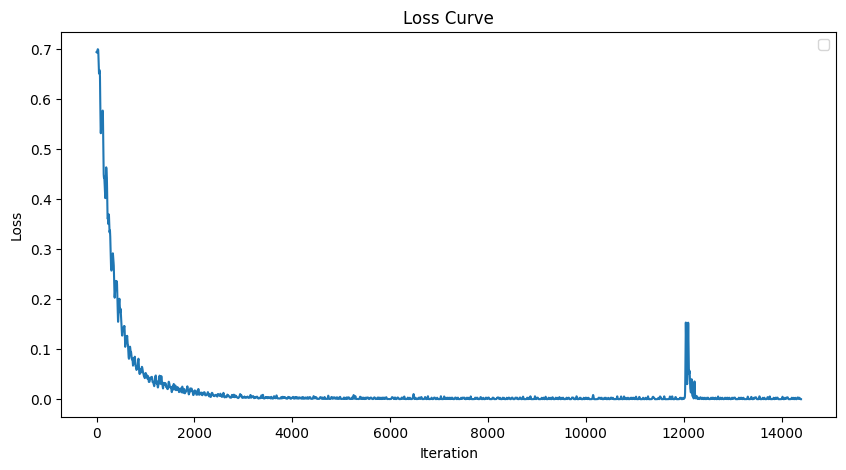

In [ ]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

#print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
#plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

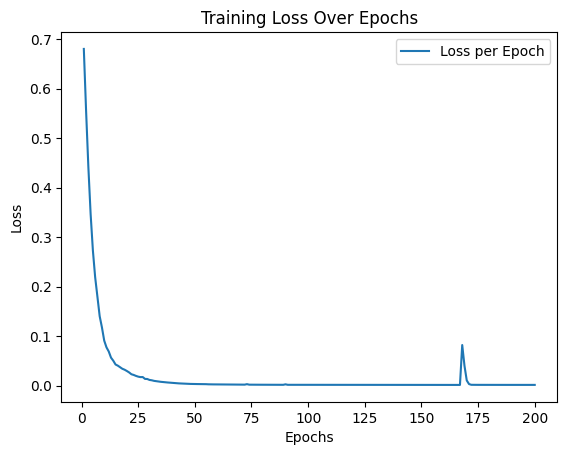

In [ ]:
num_epochs = train_config['num_epochs']
num_minibatches_per_epoch = len(loss_hist) // num_epochs

# Create x-axis values in terms of epochs
epochs = np.linspace(1, num_epochs, len(loss_hist))
epoch_losses = np.array(loss_hist).reshape(num_epochs, num_minibatches_per_epoch).mean(axis=1)

plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

C:\Users\knsve\AppData\Local\Temp\ipykernel_23188\1552820167.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


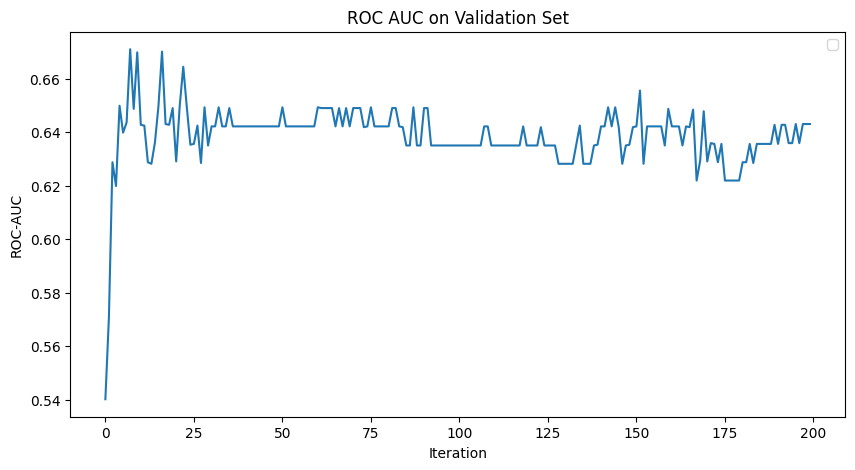

In [ ]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

#plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.plot(val_auc_hist)
plt.title("ROC AUC on Validation Set")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [ ]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

# TODO: Add neuron thresholds to name
filename = make_filename(dirname, target_name, net_type, data_config, lr, weight_decay, optim_type, net_config, train_config, model)
if save_csv: df_metrics.to_csv(filename, index=False)

print(filename)

Accuracy:  0.661 ± 0.038
AUC ROC: 0.660 ± 0.039
Sensitivity: 0.669 ± 0.048
Specificity: 0.651 ± 0.056


KeyError: 'repr_type'

In [ ]:
min_auc = np.argmin(results[1])
print("min auc:", results[1][min_auc], "at", min_auc)

max_auc = np.argmax(results[1])
print("max auc:", results[1][max_auc], "at", max_auc)